In [97]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_plot_function as theodo_p
import scripts.groundtruth_utils as theodo_g
from scipy.spatial.transform import Rotation as R
from numpy import linalg
import importlib
import matplotlib as mpl
theodo_u = importlib.reload(theodo_u)
theodo_p = importlib.reload(theodo_p)

In [120]:
theodo_u = importlib.reload(theodo_u)

path = "../data/20221109-2/"
Pose_S = theodo_u.read_pose_uncertainty_sorted(path+"uncertainty/sensor/GNSS_2_0_0_0_0_0.csv")
model_chosen = "MC_Fake_0_0_0_0_0_5"
P1 = theodo_u.read_point_uncertainty_csv_file(path+"uncertainty/interpolation/"+model_chosen+"_1.csv")
P2 = theodo_u.read_point_uncertainty_csv_file(path+"uncertainty/interpolation/"+model_chosen+"_2.csv")
P3 = theodo_u.read_point_uncertainty_csv_file(path+"uncertainty/interpolation/"+model_chosen+"_3.csv")

#GPS_raw_data = theodo_u.read_gps_file(path + "gps_data/front.pos", 25)
GPS_raw_data = theodo_u.read_gps_file(path + "gps_data/back.pos", 25)
#GPS_raw_data = theodo_u.read_gps_file(path + "gps_data/front.pos", 25)
limit_data_front = np.array([0,1000000,0])
GPS_utm_data = theodo_u.utm_gps_data(GPS_raw_data, limit_data_front, False)

Average satellite number: 13.6 , Std:  2.7 , Min : 2.0 , Max : 20.0


In [165]:
Point_1 = []
Point_2 = []
Point_3 = []
Point_S = []
Cov_1 = []
Cov_2 = []
Cov_3 = []
Cov_S = []
for i,j,k,l in zip(P1,P2,P3,Pose_S):
    Point_1.append([i[1][0],i[1][1],i[1][2],1])
    Point_2.append([j[1][0],j[1][1],j[1][2],1])
    Point_3.append([k[1][0],k[1][1],k[1][2],1])
    Point_S.append([l[1][0],l[1][1],l[1][2],1])
    Cov_1.append(i[2])
    Cov_2.append(j[2])
    Cov_3.append(k[2])
    Cov_S.append(l[2])

R_m = R.from_euler("z", [30], degrees=True).as_matrix()
T_r = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,1]], dtype=float)
T_r[0:3,0:3] = R_m
Point_1 = T_r@np.array(Point_1).T
Point_2 = T_r@np.array(Point_2).T
Point_3 = T_r@np.array(Point_3).T
Point_S = T_r@np.array(Point_S).T
Cov_1 = np.array(Cov_1)
Cov_2 = np.array(Cov_2)
Cov_3 = np.array(Cov_3)
Cov_S = np.array(Cov_S)

GNSS_measured = []
origin = GPS_utm_data[0]
for i in GPS_utm_data:
    GNSS_measured.append(np.array([i[1]-origin[1],-(i[2]-origin[2]),i[3]-origin[3],1]))
R_m = R.from_euler("z", [17.8], degrees=True).as_matrix()
T_r = np.array([[1,0,0,-2.45],
              [0,1,0,-4.43],
              [0,0,1,0],
              [0,0,0,1]], dtype=float)
T_r[0:3,0:3] = R_m
GNSS_measured = T_r@np.array(GNSS_measured).T

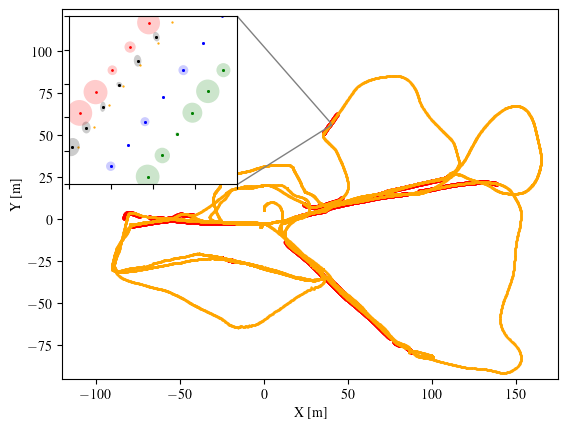

In [173]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline
mpl.rcParams['text.usetex'] = True
#mpl.use('pdf')
width = 3.487
height = width/1.618

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
font_size = 10

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(Point_1[0,:],Point_1[1,:], color='red', s=4)
# ax.scatter(Point_2[0,:],Point_2[1,:], color='blue', s=4)
# ax.scatter(Point_3[0,:],Point_3[1,:], color='green', s=4)
# ax.scatter(Point_S[0,:],Point_S[1,:], color='black', s=1)
ax.scatter(GNSS_measured[0,:],GNSS_measured[1,:], color='orange', s=0.4)
ax.axis('Equal')
ax.set_xlim(-120,175)
ax.set_ylim(-170,200)
ax.set_xlabel("X [m]",fontsize = font_size)
ax.set_ylabel("Y [m]",fontsize = font_size)

axins = zoomed_inset_axes(ax, 100, loc='upper left')
#axins.scatter(Point_1[0,:],Point_1[1,:], color='red', s=1)
axins.scatter(Point_2[0,:],Point_2[1,:], color='blue', s=1)
axins.scatter(Point_3[0,:],Point_3[1,:], color='green', s=1)
axins.scatter(Point_S[0,:],Point_S[1,:], color='black', s=1)
axins.scatter(GNSS_measured[0,:],GNSS_measured[1,:], color='orange', s=0.4)
for i,j in zip(Point_1.T,Cov_1):
    if 39<i[0]<40 and 56<i[1]<57:
        theodo_g.plot_ellipse(plt.gca(), [i[0],i[1]], j, n_std=1, color="red")
        axins.scatter(i[0],i[1], color='red', s=1)
for i,j in zip(Point_2.T,Cov_2):
    if 39<i[0]<40 and 56<i[1]<57:
        theodo_g.plot_ellipse(plt.gca(), [i[0],i[1]], j, n_std=1, color="blue")
        axins.scatter(i[0],i[1], color='blue', s=1)
for i,j in zip(Point_3.T,Cov_3):
    if 39<i[0]<40 and 56<i[1]<57:
        theodo_g.plot_ellipse(plt.gca(), [i[0],i[1]], j, n_std=1, color="green")
        axins.scatter(i[0],i[1], color='green', s=1)
for i,j in zip(Point_S.T,Cov_S):
    if 39<i[0]<40 and 56<i[1]<57:
        theodo_g.plot_ellipse(plt.gca(), [i[0],i[1]], j, n_std=1, color="black")
        axins.scatter(i[0],i[1], color='black', s=1)
axins.set_xlim(39, 40)
axins.set_ylim(56, 57)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.savefig("../figs/uncertainty/pose_example.pdf")
plt.show()

[25.81639336 25.81658899 25.81676646 ... 57.37525022 57.48951419
 57.6085222 ]
[-24.35063356 -24.35083536 -24.35100466 ... -52.41149362 -52.52037829
 -52.63371814]
[0.50229081 0.5023041  0.50232301 ... 0.26477607 0.26465135 0.26454047]
[1. 1. 1. ... 1. 1. 1.]


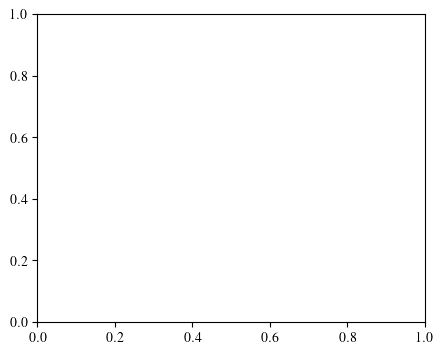

In [108]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

fig, ax = plt.subplots(figsize=(5,4))
for i,j in zip(Point_1,Cov_1):
    print(i)
    if 39<i[0]<40 and 56<i[1]<57:
        print("ok")
        theodo_g.plot_ellipse(plt.gca(), [i[0],i[1]], j, n_std=1, color="red")
        ax.scatter(i[0],i[1])
plt.show()